In [232]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

##  Novel Coronavirus: Data Science and Machine Learning Visualizations

This is the site where I pull the recent `.csv` files: https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases

This notebook uses the confimed, deaths, and recovered database

In [233]:
!ls

COVID19 Visualizations.ipynb        time_series_2019-ncov-Deaths.csv
time_series_2019-ncov-Confirmed.csv time_series_2019-ncov-Recovered.csv


In [234]:
#Load the CSV files. Please make sure to pull the latest files from the website
COVID19_confirmed = pd.read_csv("time_series_2019-ncov-Confirmed.csv")
COVID19_deaths = pd.read_csv("time_series_2019-ncov-Deaths.csv")
COVID19_recovered = pd.read_csv("time_series_2019-ncov-Recovered.csv")

In [235]:
COVID19_confirmed.head(20)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,70,75,82,114,147,177,212,272,322,411
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,639,701,773,839,825,878,889,924,963,1007
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,178,200,212,226,243,266,313,345,385,432
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,149,197,238,428,566,673,790,900,1030,1183
5,British Columbia,Canada,49.2827,-123.1207,0,0,0,0,0,0,...,46,64,64,73,103,103,186,231,271,424
6,New South Wales,Australia,-33.8688,151.2093,0,0,0,0,3,4,...,65,92,112,134,171,210,267,307,353,436
7,Victoria,Australia,-37.8136,144.9631,0,0,0,0,1,1,...,21,36,49,57,71,94,121,121,121,229
8,Queensland,Australia,-28.0167,153.4000,0,0,0,0,0,0,...,20,35,46,61,68,78,94,144,184,221
9,NaN,Cambodia,11.5500,104.9167,0,0,0,0,0,1,...,3,5,7,7,7,33,35,37,51,53


In [236]:
#Lat and Long data could be used later or map visualization
COVID19_confirmed = COVID19_confirmed.drop(['Lat', 'Long'], axis=1)
COVID19_deaths = COVID19_deaths.drop(['Lat', 'Long'], axis=1)
COVID19_recovered = COVID19_recovered.drop(['Lat', 'Long'], axis=1)

I don't know how to filter out the NaN for smaller countries for no provinces/states, so I split the data into two sections between big countries and small countries helper functions. Everything should work smoothly.

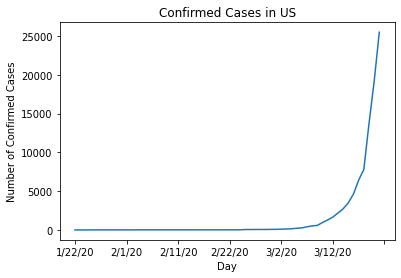

In [237]:
def small_country(country_name, data):
    big_countries = ['Australia', 'Canada', 'China', 'Cruise Ship', 'Denmark', 'France', 'Netherlands', 'US', 'United Kingdom']
    if country_name in big_countries:
        print("Country you inputted is a big country. Please type in provice/state, or use big_country()")
        return
    country = data
    country = country.pivot_table(index=['Country/Region'])
    country = country.loc[country_name].sort_values().plot()

    #Need to sort the dates
    
    if data.equals(COVID19_confirmed):
        dataType = "Confirmed Cases"
    elif data.equals(COVID19_recovered):
        dataType = "Recovered"
    elif data.equals(COVID19_deaths):
        dataType = "Deaths"
    
    #Labelings
    country.set_ylabel("Number of " + dataType)
    country.set_xlabel("Day")
    country.set_title(dataType + " in " + country_name)
    return country

def big_country(country_name, data):
    country = data
    country = country.pivot_table(index=['Country/Region', 'Province/State'])
    country = country.groupby(level=[0]).sum()
    country = country.loc[country_name].sort_values().plot()

    if data.equals(COVID19_confirmed):
        dataType = "Confirmed Cases"
    elif data.equals(COVID19_recovered):
        dataType = "Recovered"
    elif data.equals(COVID19_deaths):
        dataType = "Deaths"
    
    #Labelings
    country.set_ylabel("Number of " + dataType)
    country.set_xlabel("Day")
    country.set_title(dataType + " in " + country_name)
    return country

def country(country_name, data):
    big_countries = ['Australia', 'Canada', 'China', 'Cruise Ship', 
                       'Denmark', 'France', 'Netherlands', 'US', 'United Kingdom']
    if country_name in big_countries:
        return big_country(country_name, data)
    else:
        return small_country(country_name, data)
    
country("US", COVID19_confirmed)   

In [238]:
"""def barChart():
    barChart = country.plot()
    barChart.set_ylabel("Number of Cases")
    barChart.set_xlabel("Date")
    barChart.set_title("COVID 19 Cases Confirmed in _Country_");
    
    
def lineGraph():
    return None"""

'def barChart():\n    barChart = country.plot()\n    barChart.set_ylabel("Number of Cases")\n    barChart.set_xlabel("Date")\n    barChart.set_title("COVID 19 Cases Confirmed in _Country_");\n    \n    \ndef lineGraph():\n    return None'

In [239]:
"""plot = country.loc[('China', 'Anhui')].plot()
plot.set_ylabel("Number of Confirmed Cases")
plot.set_xlabel("Time")
plot.set_title("Confirmed Cases in Anhui, China")"""

'plot = country.loc[(\'China\', \'Anhui\')].plot()\nplot.set_ylabel("Number of Confirmed Cases")\nplot.set_xlabel("Time")\nplot.set_title("Confirmed Cases in Anhui, China")'